In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  %pip install --quiet git+https://github.com/raulonlab/crypto-band-indicators#egg=crypto_band_indicators

import backtrader as bt
from crypto_band_indicators.backtrader import RebalanceStrategy, WeightedDCAStrategy, DCAStrategy, HodlStrategy
from crypto_band_indicators.datas import TickerDataSource, FngDataSource
from crypto_band_indicators.indicators import FngBandIndicator, RainbowBandIndicator
from crypto_band_indicators import config
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

# Global variables and ininitialisations
ticker_data_source = TickerDataSource().load()
FngDataSource().load()  # Preload cache
config.set(config.ONLY_CACHE, True)
config.set(config.ENABLE_BACKTRADER_LOG, False)  # Disable backtrader log output

# Optimise strategies

Run a simulation of all the indicators / strategies in order to get the best parameters for a given dates

Strategies:
- **Rebalance**: Applies a rebalance of the position of BTC over the total depending on the current indicator band.
- **Weighted DCA**: Variation of the traditional Dollar Cost Average (DCA) where the periodic order size changes depending on the current indicator band.
- **Hold**: Dummy buy and hold
- **Standard DCA**: Dummy DCA strategy 

Indicators:
- **Fear and Greed**
- **Rainbow**

### Parameters and dates

In [2]:
# Fixed parameters
initial_cash        = 10000.0       # initial broker cash. Default 10000 usd
base_buy_amount     = 100           # Amount purchased in standard DCA

# Weighted multipliers and rebalance percents
fng_weighted_multipliers =  [1.5, 1.25, 1, 0.75, 0.5]  # buy amount multipliers (weighted) for FnG bands
fng_rebalance_percents   =  [85, 65, 50, 15, 10]       # rebalance percentages (BTC/total) for FnG bands
rwa_weighted_multipliers =  [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4]  # buy amount multipliers for Rainbow bands
rwa_rebalance_percents   =  [10, 20, 30, 40, 50, 60, 70, 80, 90]         # rebalance percentages for Rainbow band

# Range variables (to calculate optimization)
min_order_period_list    = range(4, 8)              # Minimum period in days to place orders
# indicator ta_config: smooths data variations by using a MA algorithm. See https://github.com/twopirllc/pandas-ta
indicator_ta_config_list    = [
    None,
    {'kind': 'sma', 'length': 3},
    {'kind': 'sma', 'length': 5},
    {'kind': 'wma', 'length': 2},
    {'kind': 'wma', 'length': 4},
]
# Don't apply MA algorithm to indicator
# indicator_ta_config_list        = (None,)

# Don't apply MA algorithm to strategy
ta_column_list = (None,)

# Dates
start               = '01/01/2021'  # start date of the simulation. Ex: '01/01/2020' or None
end                 = '31/12/2021'  # end date of the simulation. Ex: '31/12/2020' or None

### Run simulation

In [3]:
def run(strategy_class, **kwargs):
    cerebro = bt.Cerebro(stdstats=False, optreturn=False, maxcpus=1, runonce=True, exactbars=False)
    cerebro.broker.set_coc(True)

    # Add strategy
    cerebro.optstrategy(strategy_class,
                        **kwargs)

    # Add data feed
    cerebro.adddata(ticker_data_source.to_backtrade_feed(start, end))

    # Add cash to the virtual broker
    cerebro.broker.setcash(initial_cash)

    cerebro_results = cerebro.run()
    print(f"✔ Done {strategy_class.__name__}")

    return cerebro_results


rebalance_run_results = list()
wdca_run_results = list()

# HODL
run_result = run(strategy_class=HodlStrategy,
                percent=(100,),
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Rebalance strategy with Fear and Greed indicator
run_result = run(
    strategy_class=RebalanceStrategy,
    indicator_class=(FngBandIndicator,),
    indicator_ta_config=indicator_ta_config_list,
    ta_column=ta_column_list,
    min_order_period=min_order_period_list,
    rebalance_percents=(fng_rebalance_percents,),
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Rebalance strategy with Rainbow indicator
run_result = run(
    strategy_class=RebalanceStrategy,
    indicator_class=(RainbowBandIndicator,),
    indicator_ta_config=indicator_ta_config_list,
    ta_column=ta_column_list,
    min_order_period=min_order_period_list,
    rebalance_percents=(rwa_rebalance_percents,),
)
rebalance_run_results.extend(map(lambda result: result[0], run_result))

# Standard DCA
run_result = run(
    strategy_class=DCAStrategy,
    buy_amount=(base_buy_amount,),
    min_order_period=min_order_period_list,
)
wdca_run_results.extend(map(lambda result: result[0], run_result))

# Weighted Av strategy with Fear and Greed indicator
run_result = run(
    strategy_class=WeightedDCAStrategy,
    indicator_class=(FngBandIndicator,),
    indicator_ta_config=indicator_ta_config_list,
    # ta_column=ta_column_list,   # Not used in Weighed Avg
    base_buy_amount=(base_buy_amount,),
    min_order_period=min_order_period_list,
    weighted_multipliers=(fng_weighted_multipliers,),
)
wdca_run_results.extend(map(lambda result: result[0], run_result))

# Weighted Av strategy with Rainbow indicator
run_result = run(
    strategy_class=WeightedDCAStrategy,
    indicator_class=(RainbowBandIndicator,),
    indicator_ta_config=indicator_ta_config_list,
    # ta_column=ta_column_list,   # Not used in Weighed Avg
    base_buy_amount=(base_buy_amount,),
    min_order_period=min_order_period_list,
    weighted_multipliers=(rwa_weighted_multipliers,),
)
wdca_run_results.extend(map(lambda result: result[0], run_result))

# Sort results by pnl_value descendent (best value first)
sorted_rebalance_run_results = sorted(rebalance_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)
sorted_wdca_run_results = sorted(wdca_run_results, key=lambda strategy: float(strategy.pnl_value), reverse=True)

✔ Done HodlStrategy
✔ Done RebalanceStrategy
✔ Done RebalanceStrategy
✔ Done DCAStrategy
✔ Done WeightedDCAStrategy
✔ Done WeightedDCAStrategy


### Show results

In [4]:

column_keys = ['name', 'pnl_value', 'pnl_percent', 'params']
column_headers = ['Strategy', 'PNL USDT', 'PNL %', 'Parameters']

sorted_rebalance_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_rebalance_run_results)
print('REBALANCE results:\n')
print(tabulate([details.values() for details in sorted_rebalance_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt="+.2f"))

sorted_wdca_run_details = map(lambda strategy: strategy.describe(keys=column_keys), sorted_wdca_run_results)
print('\nWEIGHTED DCA results:\n')
print(tabulate([details.values() for details in sorted_wdca_run_details], 
                tablefmt="github", 
                headers=column_headers, 
                floatfmt="+.2f"))

REBALANCE results:

| Strategy                 |   PNL USDT |   PNL % | Parameters                       |
|--------------------------|------------|---------|----------------------------------|
| HODL 100%                |   +6262.52 |  +62.63 | 100%                             |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 4, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 5, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 6, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 7, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 4, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 5, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 6, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow        |   +3981.19 |  +39.81 | 7, [10,20,30,40,50,60,70,80,90], |
| Rebalance Rainbow    

### Plot results

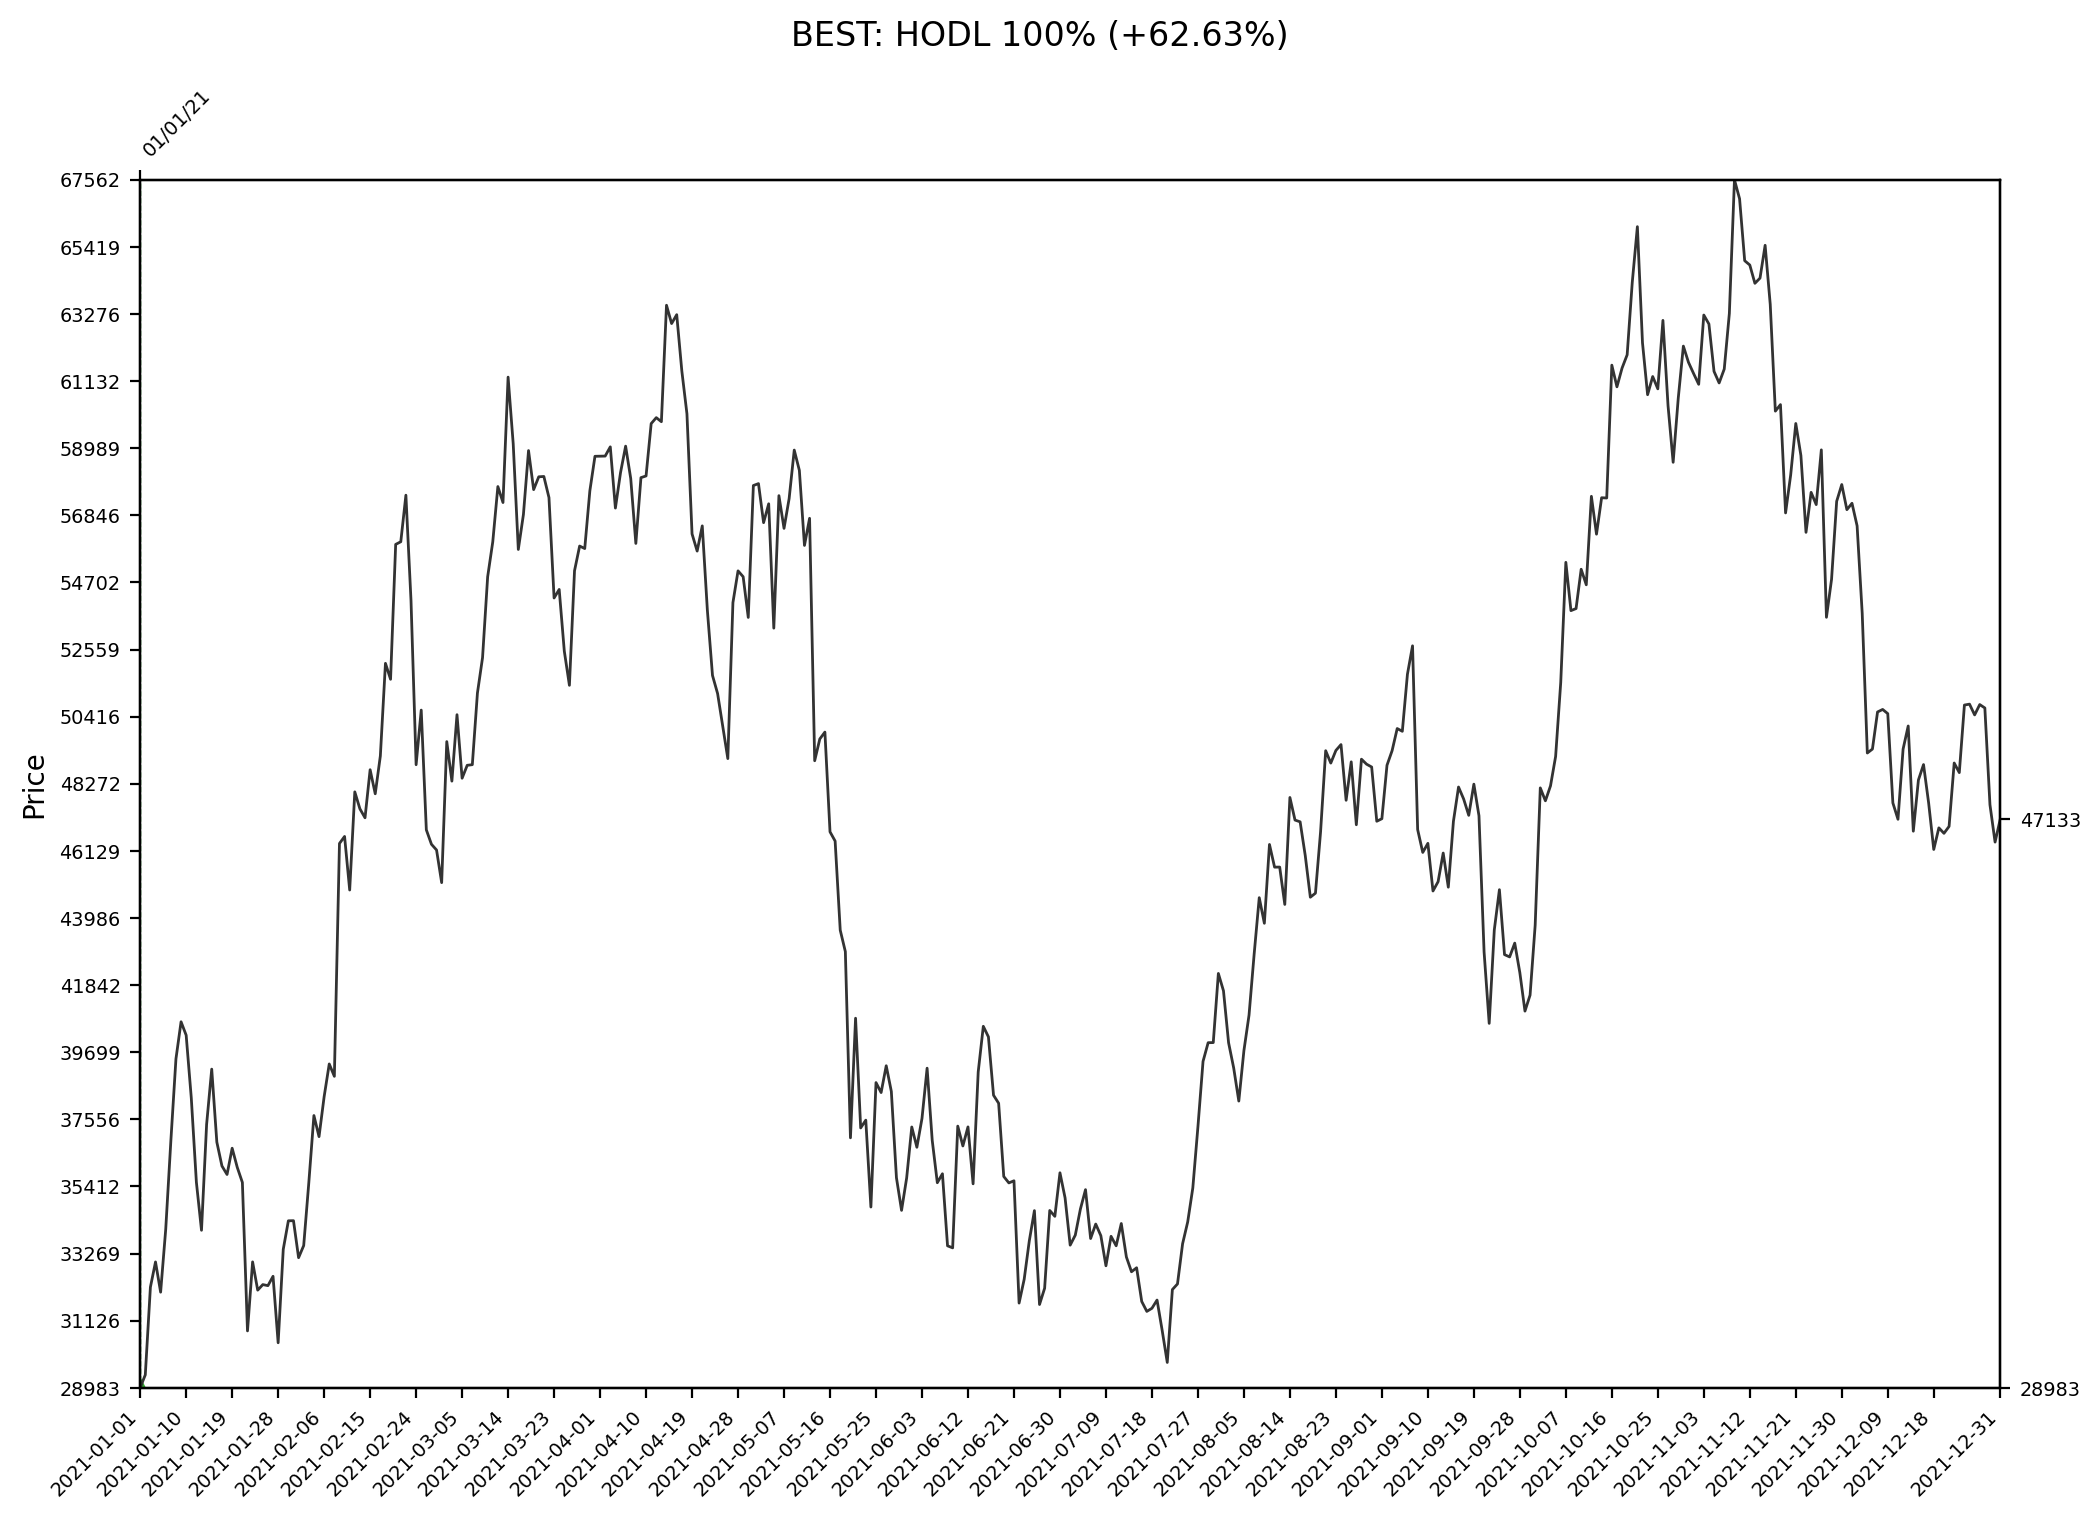

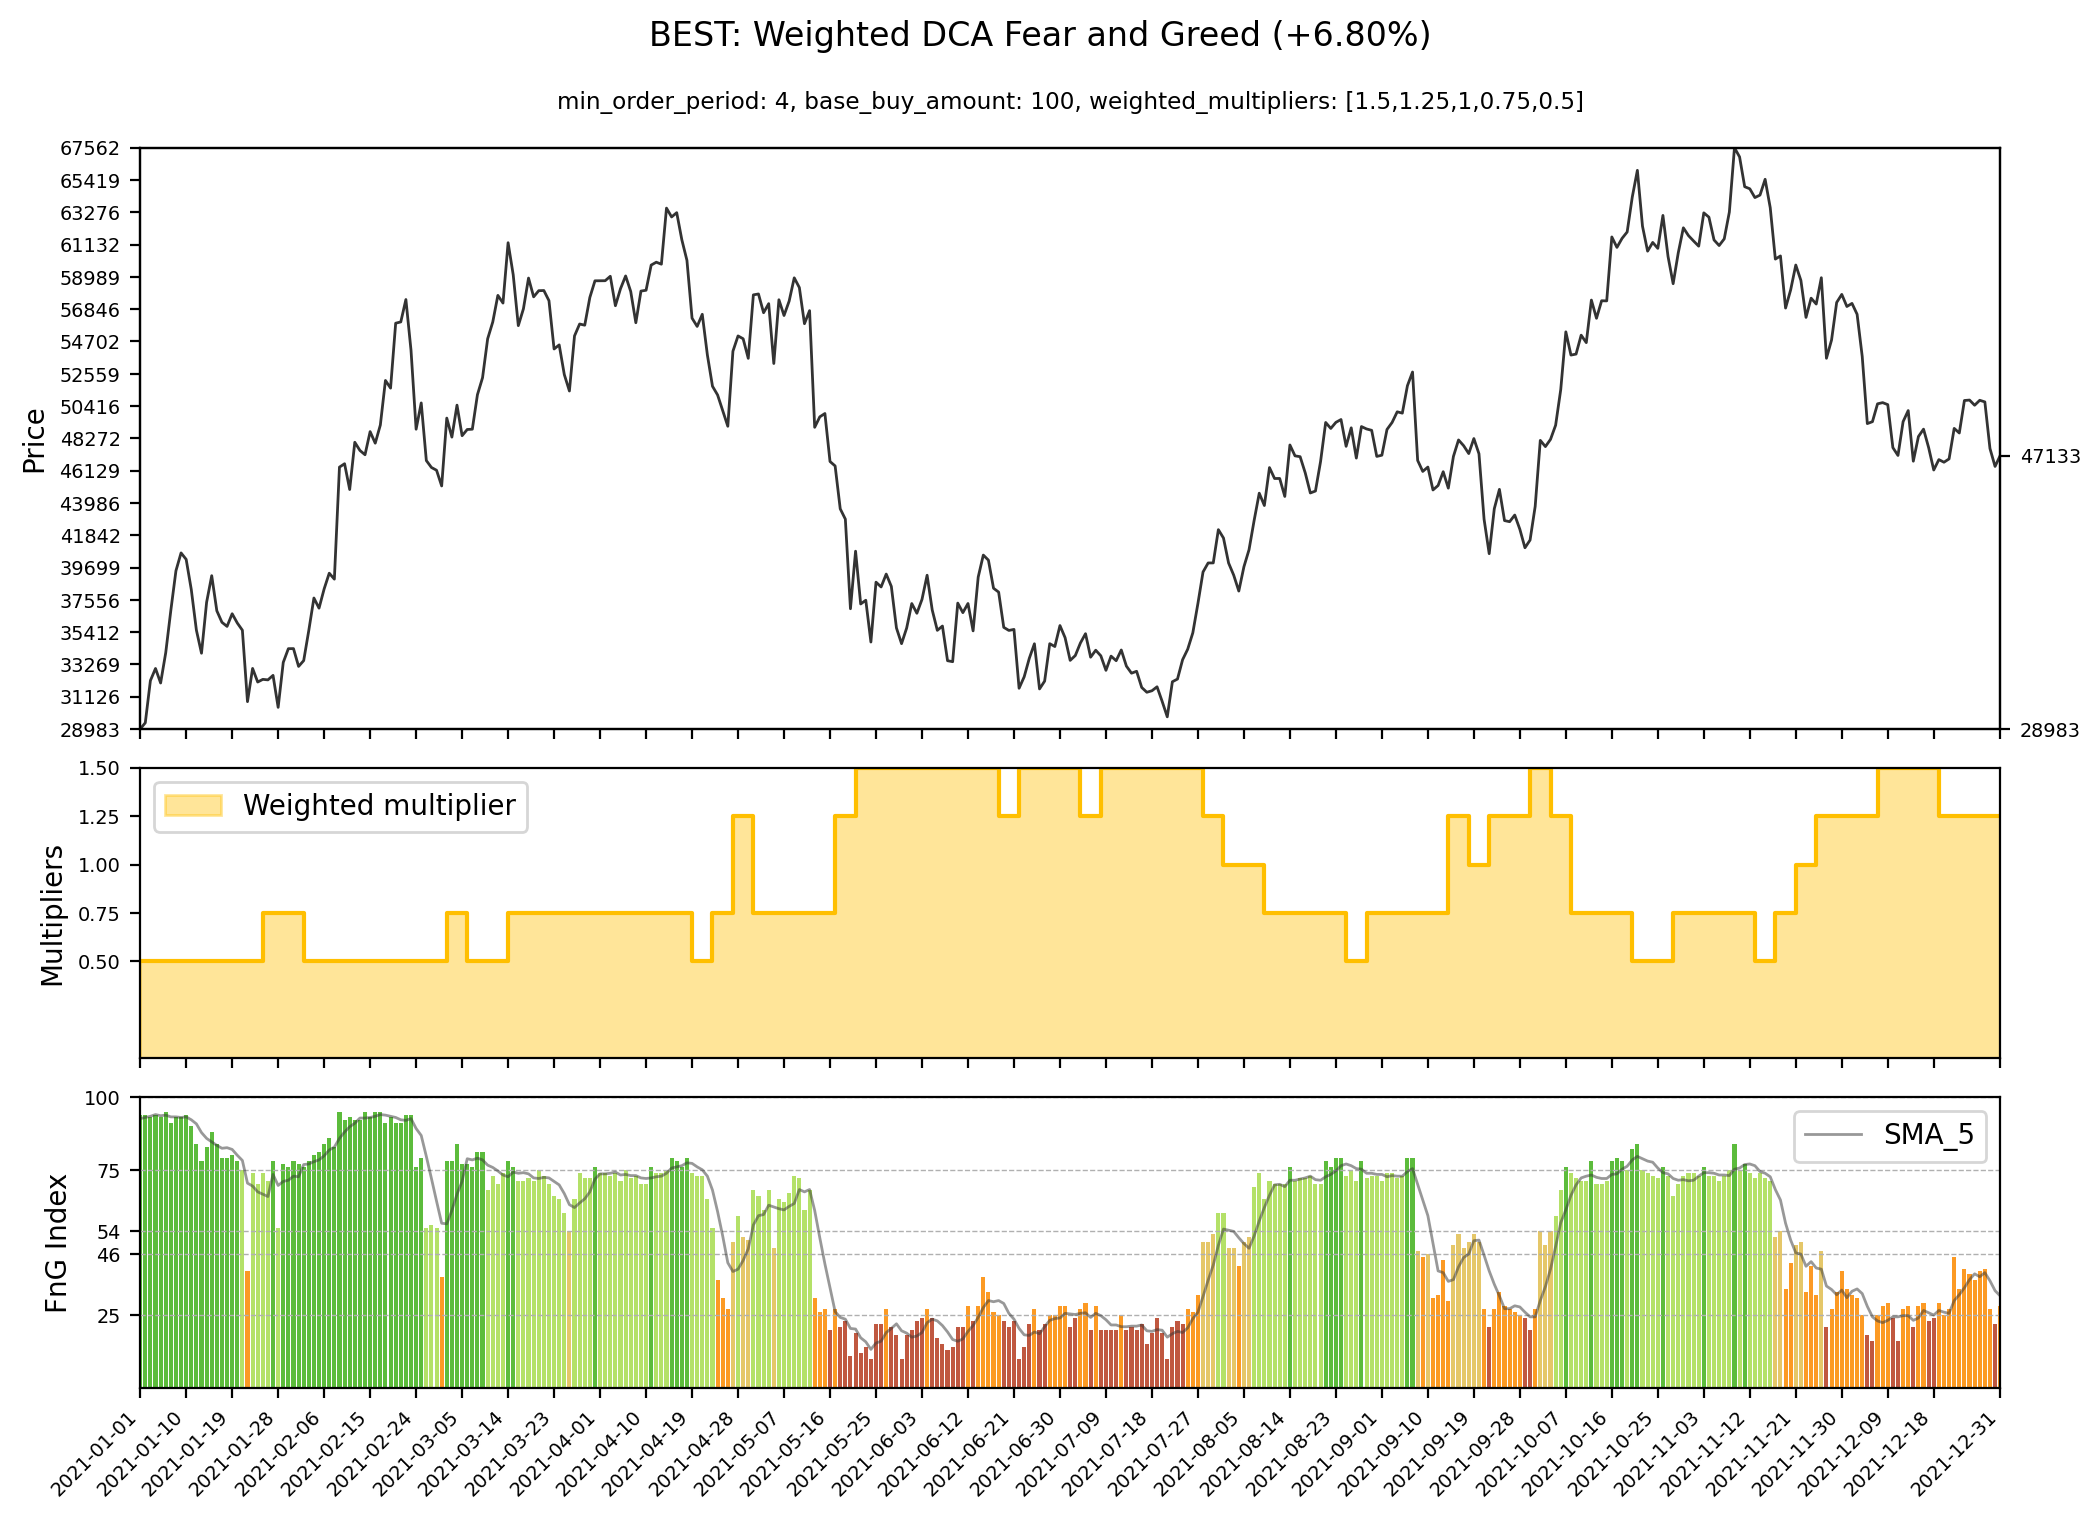

In [5]:
# %matplotlib widget      # Enable interactive plots

plot_results = True
plot_only_winner = True

if plot_results:
    for i in range(0, len(sorted_rebalance_run_results)):
        sorted_rebalance_run_results[i].plot(title_prefix='BEST: ' if i == 0 else '', title_suffix=f" ({sorted_rebalance_run_results[i].pnl_percent:+.2f}%)")

        if plot_only_winner:
            break
    
    for i in range(0, len(sorted_wdca_run_results)):
        sorted_wdca_run_results[i].plot(title_prefix='BEST: ' if i == 0 else '', title_suffix=f" ({sorted_wdca_run_results[i].pnl_percent:+.2f}%)")

        if plot_only_winner:
            break
